![](https://www.pata.org/wp-content/uploads/2014/09/TripAdvisor_Logo-300x119.png)
# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor
**По ходу задачи:**
* Прокачаем работу с pandas
* Научимся работать с Kaggle Notebooks
* Поймем как делать предобработку различных данных
* Научимся работать с пропущенными данными (Nan)
* Познакомимся с различными видами кодирования признаков
* Немного попробуем [Feature Engineering](https://ru.wikipedia.org/wiki/Конструирование_признаков) (генерировать новые признаки)
* И совсем немного затронем ML
* И многое другое...   



### И самое важное, все это вы сможете сделать самостоятельно!

*Этот Ноутбук являетсся Примером/Шаблоном к этому соревнованию (Baseline) и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.

> что такое baseline решение, зачем оно нужно и почему предоставлять baseline к соревнованию стало важным стандартом на kaggle и других площадках.   
**baseline** создается больше как шаблон, где можно посмотреть как происходит обращение с входящими данными и что нужно получить на выходе. При этом МЛ начинка может быть достаточно простой, просто для примера. Это помогает быстрее приступить к самому МЛ, а не тратить ценное время на чисто инженерные задачи. 
Также baseline являеться хорошей опорной точкой по метрике. Если твое решение хуже baseline - ты явно делаешь что-то не то и стоит попробовать другой путь) 

В контексте нашего соревнования baseline идет с небольшими примерами того, что можно делать с данными, и с инструкцией, что делать дальше, чтобы улучшить результат.  Вообще готовым решением это сложно назвать, так как используются всего 2 самых простых признака (а остальные исключаются).

# import

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns 
import missingno as msno
%matplotlib inline
sns.set()

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

Загрузим датасеты. Добавим дополнительный датасет по городам. Далее попробуем достать из него полезные нам признаки.

In [4]:
df_train = pd.read_csv('main_task.csv')
df_test = pd.read_csv('kaggle_task.csv')
sample_submission = pd.read_csv('sample_submission.csv')
df_city = pd.read_csv('worldcities.csv')
cost = pd.read_csv('cost of living 2020.csv')

In [5]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 2.0+ MB


In [7]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      10000 non-null  object 
 1   City               10000 non-null  object 
 2   Cuisine Style      7693 non-null   object 
 3   Ranking            10000 non-null  float64
 4   Price Range        6525 non-null   object 
 5   Number of Reviews  9343 non-null   float64
 6   Reviews            9998 non-null   object 
 7   URL_TA             10000 non-null  object 
 8   ID_TA              10000 non-null  object 
dtypes: float64(2), object(7)
memory usage: 429.8+ KB


In [9]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [10]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [11]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Restaurant_id  10000 non-null  object 
 1   Rating         10000 non-null  float64
dtypes: float64(1), object(1)
memory usage: 117.2+ KB


In [12]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечае, где у нас трейн
df_test['sample'] = 0 # помечаем, где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, поэтому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 2.9+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [14]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
29590,id_761,Paris,"['Italian', 'Pizza', 'Vegetarian Friendly']",762.0,$$ - $$$,500.0,"[['Nice Italian in Paris', 'Lovely place and a...",/Restaurant_Review-g187147-d1100089-Reviews-Pi...,d1100089,1,4.0
33055,id_12903,Paris,"['French', 'European']",12905.0,$$ - $$$,137.0,"[['Average', 'Could have been better'], ['10/1...",/Restaurant_Review-g187147-d4167583-Reviews-La...,d4167583,1,3.0
4956,id_4956,Munich,"['Greek', 'Seafood']",2314.0,$$ - $$$,44.0,"[['Lovely family restaurant and good food', 'E...",/Restaurant_Review-g187309-d2714891-Reviews-Di...,d2714891,0,0.0
18190,id_2373,Amsterdam,NaN,2379.0,NaN,2.0,"[[], []]",/Restaurant_Review-g188590-d12814346-Reviews-B...,d12814346,1,4.5
42216,id_612,Brussels,"['Belgian', 'Cafe', 'European', 'Delicatessen'...",613.0,$$ - $$$,15.0,"[['Chocolate', 'Gorgeous'], ['02/10/2018', '03...",/Restaurant_Review-g188644-d11748941-Reviews-M...,d11748941,1,5.0


# Cleaning and Prepping Data
Обычно данные содержат в себе кучу мусора, который необходимо почистить, для того чтобы привести их в приемлемый формат. Чистка данных — это необходимый этап решения почти любой реальной задачи.   
![](https://analyticsindiamag.com/wp-content/uploads/2018/01/data-cleaning.png)

## Обработка признаков

Пройдемся по каждому признаку и приведем предварительную обработку. Посмотрим на пропуски и создадим новые признаки.

In [15]:
data.isna().sum()

Restaurant_id            0
City                     0
Cuisine Style        11590
Ranking                  0
Price Range          17361
Number of Reviews     3200
Reviews                  2
URL_TA                   0
ID_TA                    0
sample                   0
Rating                   0
dtype: int64

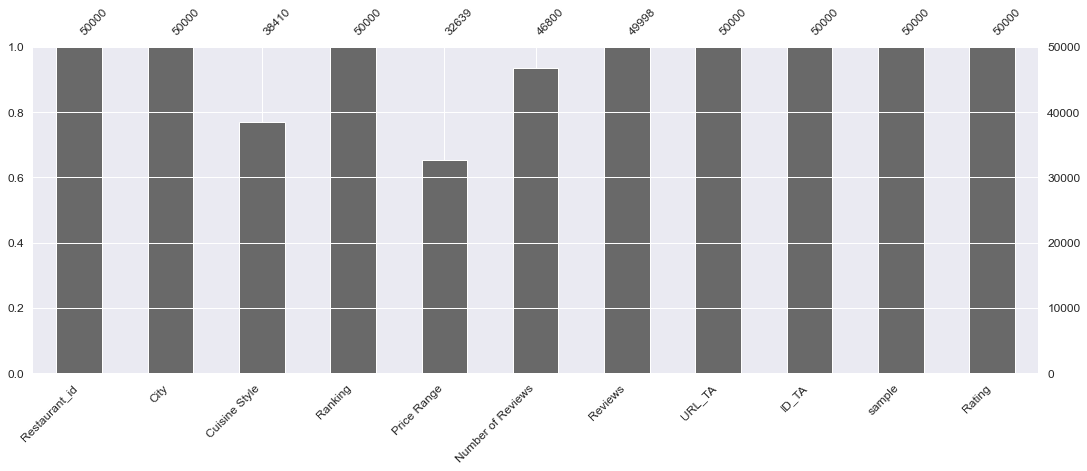

In [16]:
msno.bar(data, figsize=(18, 6),  fontsize=12);

Cuisine Style, Price Range и Number of Reviews содержат много пропусков. Далее мы их заполним и создадим новые признаки, которые будут говорить об отсутствии информации.

### Restaurant_id

In [17]:
data.Restaurant_id.value_counts()

id_436      19
id_227      19
id_871      19
id_633      19
id_321      18
            ..
id_12304     1
id_11045     1
id_7966      1
id_13295     1
id_15194     1
Name: Restaurant_id, Length: 13094, dtype: int64

Мы видим что есть повторящиеся id, возможно эти рестораны сетевые. 

Создадим новый признак chain: 1 - сетевой, 0 - несетевой.

In [18]:
chain_lst = list(data.Restaurant_id.value_counts()[data.Restaurant_id.value_counts() > 1].index)

In [19]:
data['chain'] = data[data.Restaurant_id.isin(chain_lst)].Restaurant_id.apply(lambda x: 1)
data['chain'].fillna(0, inplace=True)

In [20]:
data['chain'].value_counts()

1.0    46193
0.0     3807
Name: chain, dtype: int64

### City

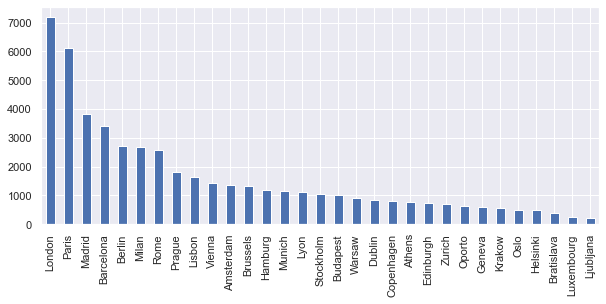

In [21]:
plt.figure(figsize=(10,4))
data.City.value_counts(ascending=False).plot(kind='bar');

Создадим список городов и найдем в добавленом датасете эти города.

In [22]:
data.loc[data.City == 'Oporto', 'City'] = 'Porto'
city_lst = data.City.unique()

In [23]:
df_city = df_city[(df_city.city_ascii.isin(city_lst)) &
                  (df_city.country != 'United States') &
                  (df_city.country != 'Canada') &
                  (df_city.country != 'Venezuela')]

In [24]:
set(city_lst) - set(df_city.city_ascii) # проверяем все ли города нашли

set()

Удалим ненужные колонки, заменим пропуски и переведем численость в млн. человек. Признак столица заменим числовыми значениями на 0 и 1

In [25]:
df_city = df_city.drop(['city', 'iso2', 'iso3', 'admin_name',  'id'], axis=1)

In [26]:
df_city['population']  = round((df_city['population'] / 1000000), 2)

In [27]:
df_city.capital.fillna('primary', inplace=True)

In [28]:
df_city['capital'] = df_city.capital.apply(lambda x: 1 if x == 'primary' else 0)

Посмотрим на датасет уровня жизни

In [29]:
country_lst = df_city['country'].tolist() 

In [30]:
cost.head(3)

,Rank 2020,Country,Cost of Living Index,Rent Index,Cost of Living Plus Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index,McMeal($),Unnamed: 9
0,1,Bermuda,147.77,85.70,117.54,146.63,152.52,78.17,0.00,NaN
1,2,Switzerland,125.69,51.20,89.41,124.93,118.55,114.83,15.36,NaN
2,3,Norway,96.80,32.61,65.54,89.55,96.81,83.40,12.36,NaN


In [31]:
cost.loc[cost.Country.str.contains('Czec'), 'Country'] = 'Czechia'
cost = cost[cost.Country.isin(country_lst)]

In [32]:
set(country_lst) - set(cost.Country)

set()

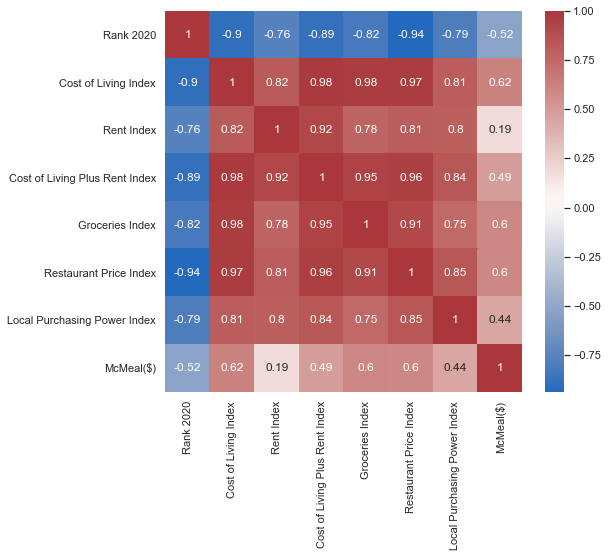

In [33]:
cost.drop('Unnamed: 9', axis=1, inplace=True)
plt.figure(figsize=(8,7))
sns.heatmap(cost.corr(), annot=True, cmap='vlag');

Все признаки хорошо скоррелированны между собой. Выбрал несколько признаков, которые на мой взгляд могут улучшить модель.

In [34]:
cost.columns

Index(['Rank 2020', 'Country', 'Cost of Living Index', 'Rent Index',
       'Cost of Living Plus Rent Index', 'Groceries Index',
       'Restaurant Price Index', 'Local Purchasing Power Index', 'McMeal($)'],
      dtype='object')

In [35]:
cost.drop(['Rent Index', 'Cost of Living Plus Rent Index',
           'Groceries Index', 'Local Purchasing Power Index' ], axis=1, inplace=True)

Объединим датасеты в один

In [36]:
df_city = df_city.join(cost.set_index('Country'), on='country')

In [37]:
data = data.join(df_city.set_index('city_ascii'), on='City')

Создадим признак количество ресторанов в городе.

In [38]:
city_counts_dict = dict(data['City'].value_counts())

In [39]:
data['rest_counts'] = data.City.map(city_counts_dict)

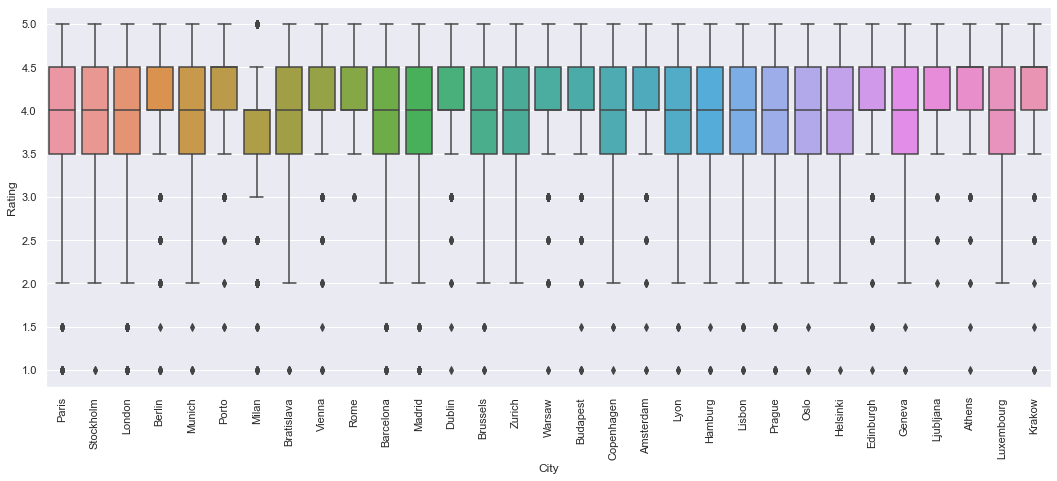

In [40]:
plt.figure(figsize=(18, 7))
sns.boxplot(x='City', y='Rating', data=data[data['sample'] == 1])
plt.xticks(rotation=90);

На графике можно увидеть, что рейтинг ресторанов в Rome начинаются с 3, а в Milan вероятность рейтинга с оценкой 5 очень мала. 

### Cuisine Style

In [41]:
data['Cuisine Style'][1]

"['European', 'Scandinavian', 'Gluten Free Options', 'Vegetarian Friendly', 'Vegan Options']"

Значения представлены в виде строки, обработаем их. Создадим список уникальных кухонь, представленных во всем датасете. Пропуски заполним значением 'Other', создадим колонку которая показывает было ли значение пустое.

In [42]:
data['Cuisine Style_NAN'] = data['Cuisine Style'].isna().astype('uint8')

In [43]:
data['Cuisine Style'].fillna("['Other']", inplace=True)

In [44]:
data['Cuisine Style'] = data['Cuisine Style'].apply(lambda x: eval(x))

Создадим признак 'cuisine_count' - количество представленных кухонь в ресторане.

In [45]:
data['cuisine_count'] = data['Cuisine Style'].apply(lambda x: len(x))

Посмотрим частоту встречаемости кухонь и выберем редкие (< 50)

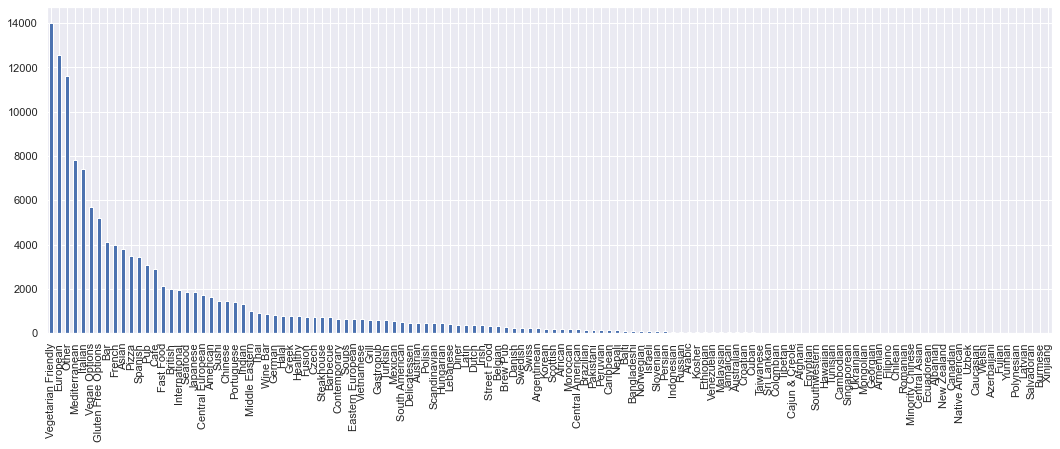

In [46]:
plt.figure(figsize=(18,6))
data.explode('Cuisine Style')['Cuisine Style'].value_counts(ascending=False).plot(kind='bar');

vegetarian friendly и european лидируют. Кухня, встречающиеся меньше 50 раз, будем считать редкими.

In [47]:
cuisine_rare_lst = data.explode('Cuisine Style')['Cuisine Style'].value_counts()[
    data.explode('Cuisine Style')['Cuisine Style'].value_counts() < 50].index.tolist()

In [48]:
def cuisine_rare_count(cell):
    '''Количество редких кухонь в ресторане'''
    x = 0
    for i in cuisine_rare_lst:
        if i in cell:
            x += 1
    return x

In [49]:
data['cuisine_rare'] = data['Cuisine Style'].apply(cuisine_rare_count)

Создадим dummy переменные кухонь

In [50]:
cuisine_lst = list(data.explode('Cuisine Style')['Cuisine Style'].unique())

In [51]:
def find_item(cell):
    if item in cell:
        return 1
    return 0
    
for item in cuisine_lst:
    data[item] = data['Cuisine Style'].apply(find_item)

### Ranking

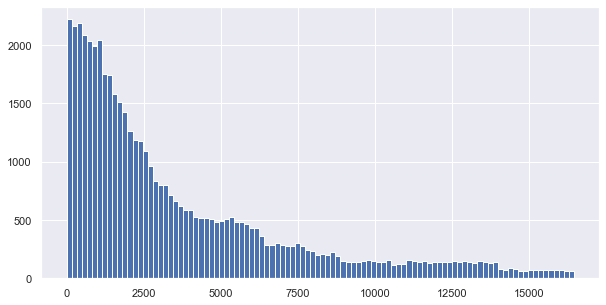

In [52]:
plt.rcParams['figure.figsize'] = (10,5)
data['Ranking'].hist(bins=100);

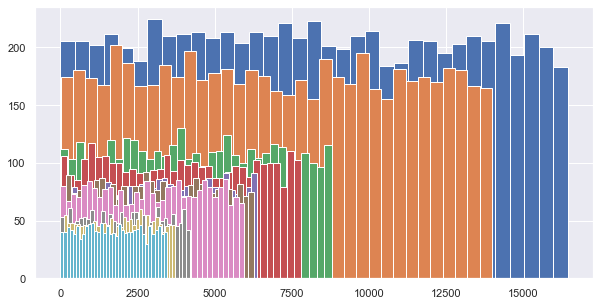

In [53]:
# посмотрим на топ 10 городов
for x in (data['City'].value_counts())[0:10].index:
    data['Ranking'][data['City'] == x].hist(bins=35)

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за этого мы имеем смещение. Разделим Ranking на количество ресторанов в городе.

In [54]:
data['ranking_norm'] = data.Ranking / data.rest_counts

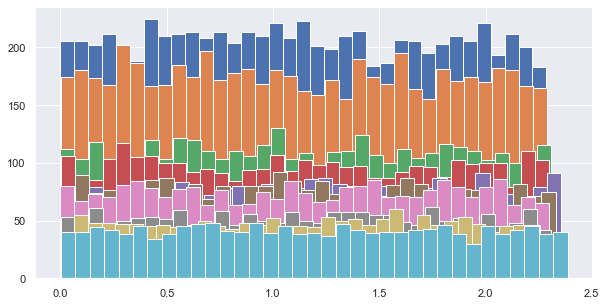

In [55]:
for x in (data['City'].value_counts())[0:10].index:
    data['ranking_norm'][data['City'] == x].hist(bins=35)

### Price Range

Заменим пропуски и изменим значения от 1 до 3. Создадим признак отсутствия информации.

In [56]:
data['Price Range'].value_counts(dropna=False)

$$ - $$$    23041
NaN         17361
$            7816
$$$$         1782
Name: Price Range, dtype: int64

In [57]:
data['Price Range_NAN'] = data['Price Range'].isna().astype('uint8')

In [58]:
for city in city_lst:
    print(city,  data[data['City'] == city]['Price Range'].mode()[0])

Paris $$ - $$$
Helsinki $$ - $$$
Edinburgh $$ - $$$
London $$ - $$$
Bratislava $$ - $$$
Lisbon $$ - $$$
Budapest $$ - $$$
Stockholm $$ - $$$
Rome $$ - $$$
Milan $$ - $$$
Munich $$ - $$$
Hamburg $$ - $$$
Prague $$ - $$$
Vienna $$ - $$$
Dublin $$ - $$$
Barcelona $$ - $$$
Brussels $$ - $$$
Madrid $$ - $$$
Oslo $$ - $$$
Amsterdam $$ - $$$
Berlin $$ - $$$
Lyon $$ - $$$
Athens $$ - $$$
Warsaw $$ - $$$
Porto $$ - $$$
Krakow $$ - $$$
Copenhagen $$ - $$$
Luxembourg $$ - $$$
Zurich $$ - $$$
Geneva $$ - $$$
Ljubljana $$ - $$$


Мода цен в ресторанах по городам одинаковая.

In [59]:
data['Price Range'].fillna(data['Price Range'].mode()[0], inplace=True)

In [60]:
price_dict = {'$': 1,
              '$$ - $$$': 2,
              '$$$$': 3}

In [61]:
data['Price Range'] = data['Price Range'].map(price_dict)

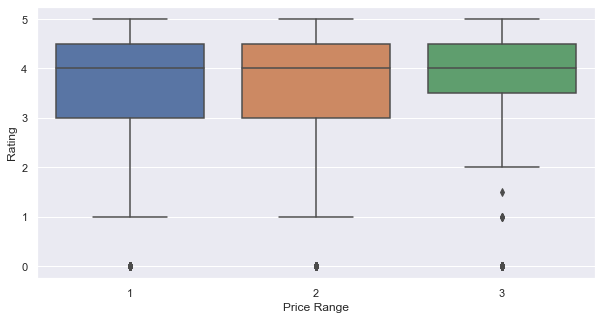

In [62]:
sns.boxplot(x='Price Range', y='Rating', data=data);

Самые дорогие рестораны реже получают низкие оценки.

### Reviews

In [63]:
data.Reviews[1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

Значения признака представлены в виде строки, но есть четкая структура списков.

In [64]:
data['Reviews'] = data.Reviews.dropna().apply(
    lambda x: eval(x.replace('nan', '').replace('[,', "['',")))

In [65]:
data['Reviews'] = data['Reviews'].dropna().apply(
    lambda x: np.nan if len(x[0]) == 0 & len(x[1]) == 0 else x)

Создадим новые признаки, reviews и date_1 date_2



In [66]:
data['date'] = data['Reviews'].dropna().apply(lambda x: x[1])
data['date_1'] = data['date'].dropna().apply(lambda x: x[1] if len(x) == 2 else np.nan)
data['date_2'] = data['date'].dropna().apply(lambda x: x[0] if len(x) > 0 else np.nan)

In [67]:
data.drop('date', axis=1, inplace=True)

Заменим пропуски в date_1 и date_2 на min и max дату соответственно. Максимальная разница количества дней между коментариями будет говорит о том, что отзывы практически не оставляют

In [68]:
data['date_1'] = pd.to_datetime(data['date_1'])
data['date_2'] = pd.to_datetime(data['date_2'])

In [69]:
data['date_1'].fillna(data['date_1'].min(), inplace=True)
data['date_2'].fillna(data['date_2'].max(), inplace=True)

Создадим признак разницы дней между последними двумя отзывами.

In [70]:
data['rewiew_days'] = abs(data['date_2'] - data['date_1']).dt.days

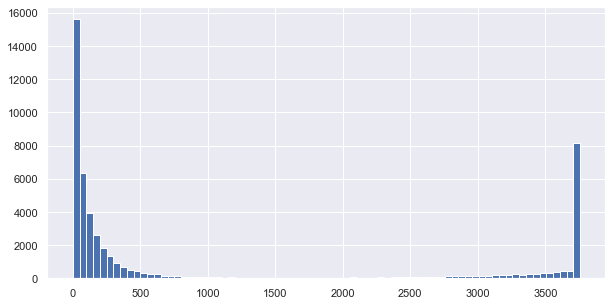

In [71]:
plt.figure(figsize=(10,5))
data['rewiew_days'].hist(bins=75);

In [72]:
data['days_to_today'] = (datetime.now() - data['date_2']).dt.days
data['days_to_today']

0        1035
1        1118
2        1095
3        1117
4        1053
         ... 
49995    1107
49996    1102
49997    1515
49998    1265
49999    1792
Name: days_to_today, Length: 50000, dtype: int64

Обработаем отзывы. Создадим признак количества последних коментариев (0-2)

In [73]:
data['Reviews'] = data['Reviews'].dropna().apply(lambda x: x[0])

In [74]:
data['last_rewiew_counts'] = data['Reviews'].dropna().apply(
    lambda x: 2 if len(x) == 2 else 1 if len(x) == 1 else 0)

In [75]:
data.last_rewiew_counts.fillna(0, inplace=True)

In [76]:
def len_rewiews(cell):
    x = 0
    for i in cell:
        x += len(i)
    return x

In [77]:
data['len_rewiews'] = data['Reviews'].dropna().apply(len_rewiews)
data['len_rewiews'].fillna(0, inplace=True)

### Number of Reviews

Посмотрим пропуски в колонке Number of Reviews

In [78]:
data[data['Number of Reviews'].isna()][['Number of Reviews', 'last_rewiew_counts']].head()

,Number of Reviews,last_rewiew_counts
7,NaN,0.0
25,NaN,0.0
53,NaN,0.0
74,NaN,1.0
81,NaN,0.0


In [79]:
data['Number of Reviews'].isna().sum()

3200

In [80]:
data.loc[(data['last_rewiew_counts'] == 0) & (
    data['Number of Reviews'].isna()), 'Number of Reviews'] = 0
data.loc[(data['last_rewiew_counts'] == 1) & (
    data['Number of Reviews'].isna()), 'Number of Reviews'] = 1

In [81]:
data['Number of Reviews'].isna().sum()

0

In [82]:
data[data['last_rewiew_counts'] ==0][['Number of Reviews', 'last_rewiew_counts']].head()

,Number of Reviews,last_rewiew_counts
0,4.0,0.0
6,2.0,0.0
7,0.0,0.0
18,2.0,0.0
20,8.0,0.0


У нас есть значения последних отзывов равные 0, хотя общее количество отзывов > 0. Это значит, что отзывы оставляли пустые.

Создадим словарь количество отзывов по городам и подставим в датасет



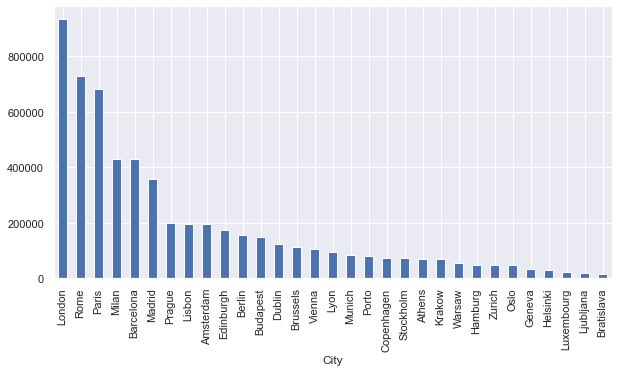

In [83]:
data.groupby('City')['Number of Reviews'].sum().sort_values(ascending=False).plot(kind='bar');

In [84]:
rewiews_city_dict = dict(data.groupby('City')['Number of Reviews'].sum())

In [85]:
data['num_rewiews_city'] = data.City.map(rewiews_city_dict)

Создадим признак отношения рейтинга в городе к количеству отзывов в городе.

In [86]:
data['relative_rank_reviews'] = data['Ranking'] / data['num_rewiews_city']

### URL_TA 

In [87]:
data['URL_TA'][0]

'/Restaurant_Review-g187147-d10746918-Reviews-Le_Perchoir-Paris_Ile_de_France.html'

Ссылки на рестораны парсить пока не умею :( удалим 

In [88]:
data.drop(['URL_TA'], axis=1, inplace=True)

### ID_TA

In [89]:
data['ID_TA'] = data['ID_TA'].apply(lambda x: int(x[1:]))

### Dummy

In [90]:
data = pd.get_dummies(data, columns=['City'])

Удалим все нечисловые признаки

In [91]:
data = data.select_dtypes(exclude='O').drop(['date_1', 'date_2', 'len_rewiews',
                                             'capital', 'Ranking', 'lat', 'lng',
                                             'chain', 'McMeal($)', 'Cost of Living Index', 
                                             'Restaurant Price Index', 'last_rewiew_counts'], axis=1)

In [92]:
data.head()

,Price Range,Number of Reviews,ID_TA,sample,Rating,population,Rank 2020,rest_counts,Cuisine Style_NAN,cuisine_count,...,City_Munich,City_Oslo,City_Paris,City_Porto,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich
0,2,4.0,10746918,0,0.0,11.02,14,6108,0,2,...,0,0,1,0,0,0,0,0,0,0
1,2,97.0,6674944,0,0.0,0.64,20,475,0,5,...,0,0,0,0,0,0,0,0,0,0
2,2,28.0,13129638,0,0.0,0.49,33,745,0,1,...,0,0,0,0,0,0,0,0,0,0
3,3,202.0,680417,0,0.0,10.98,33,7193,0,5,...,0,0,0,0,0,0,0,0,0,0
4,3,162.0,1112354,0,0.0,0.43,64,380,0,6,...,0,0,0,0,0,0,0,0,0,0


### Посмотрим распределение целевой переменной

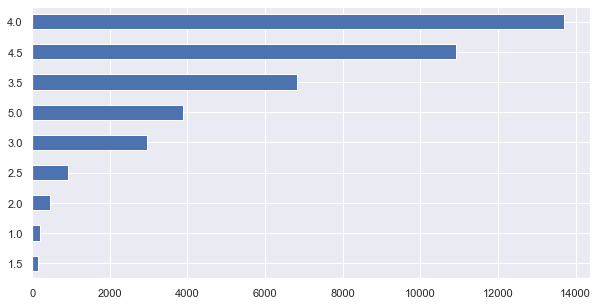

In [93]:
plt.figure(figsize=(10, 5))
df_train['Rating'].value_counts(ascending=True).plot(kind='barh');

### Посмотрим распределение целевой переменной относительно признака ranking_norm

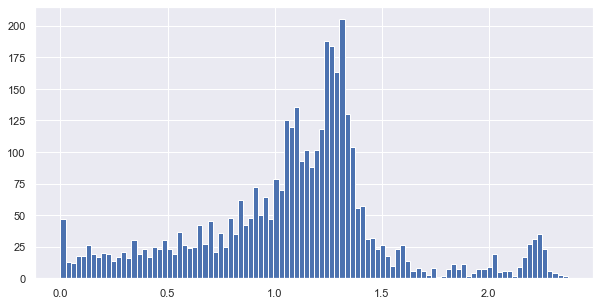

In [94]:
plt.figure(figsize=(10, 5))
data['ranking_norm'][data['Rating'] == 5].hist(bins=100);

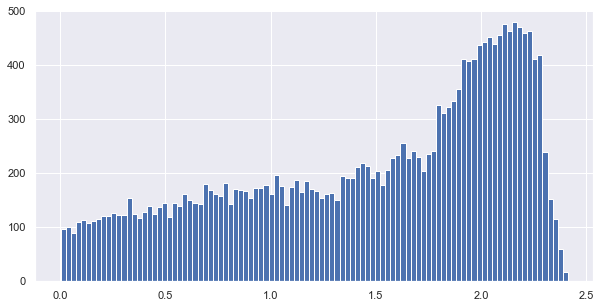

In [95]:
plt.figure(figsize=(10, 5))
data['ranking_norm'][data['Rating'] < 4].hist(bins=100);

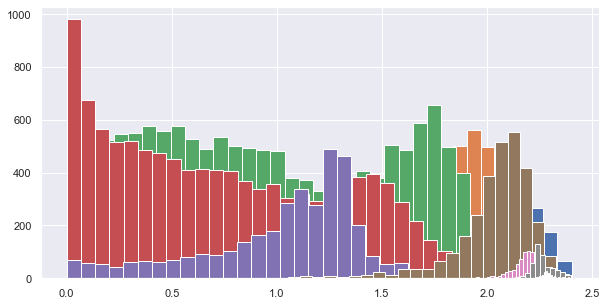

In [96]:
for x in data.Rating.unique():
    data['ranking_norm'][data['Rating'] == x].hist(bins=35)

## Корреляция признаков
На этом графике уже сейчас вы сможете заметить, как признаки связаны между собой и с целевой переменной.

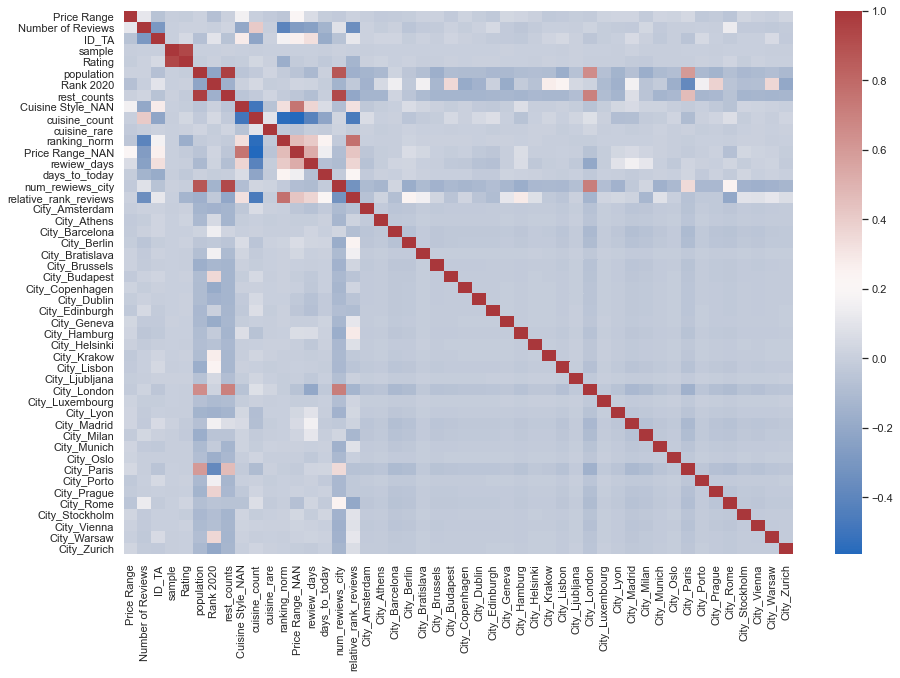

In [97]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(cuisine_lst, axis=1).corr(), cmap='vlag');

Корреляция с целевой переменной

In [98]:
data.drop(cuisine_lst, axis=1).corr().Rating.sort_values(ascending=False)

Rating                   1.000000
sample                   0.936543
ID_TA                    0.049589
cuisine_count            0.034506
City_Rome                0.027527
City_Athens              0.016852
City_Berlin              0.012834
Number of Reviews        0.011011
City_Vienna              0.010188
City_Porto               0.009654
Rank 2020                0.007732
City_Ljubljana           0.007644
City_Krakow              0.007538
City_Amsterdam           0.007447
City_Budapest            0.006301
City_Dublin              0.005758
City_Edinburgh           0.005484
cuisine_rare             0.004835
City_Geneva              0.002312
City_Hamburg             0.002112
City_Warsaw              0.001580
City_Prague              0.001123
City_Copenhagen          0.000948
City_Lisbon             -0.000081
City_Barcelona          -0.000703
City_Zurich             -0.001481
City_Bratislava         -0.002550
City_Luxembourg         -0.002940
City_Munich             -0.003420
City_Brussels 

In [99]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем, как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает до отправки submissiona на kaggle.**

In [100]:
# Воспользуемся специальной функцией train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [101]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 173), (40000, 173), (40000, 172), (32000, 172), (8000, 172))

# Model 
Сам ML

In [102]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [103]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [104]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

# # Округлим предсказанные значения до степени округления целевой переменной
# y_pred = np.round(y_pred*2)/2

def rating(prediction):
        if prediction < 0.25:
            return 0
        elif 0.25 < prediction <= 0.75:
            return 0.5
        elif 0.75 < prediction <= 1.25:
            return 1
        elif 1.25 <prediction <= 1.75:
            return 1.5
        elif 1.75 < prediction <= 2.25:
            return 2
        elif 2.25 < prediction <= 2.75:
            return 2.5
        elif 2.75 < prediction <= 3.25:
            return 3
        elif 3.25 < prediction <= 3.75:
            return 3.5
        elif 3.75 < prediction <= 4.25:
            return 4
        elif 4.25 < prediction <= 4.75:
            return 4.5
        else:
            return 5
        
for i in range(y_pred.size):
        y_pred[i]=rating(y_pred[i])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   42.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


In [105]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.159875


<AxesSubplot:>

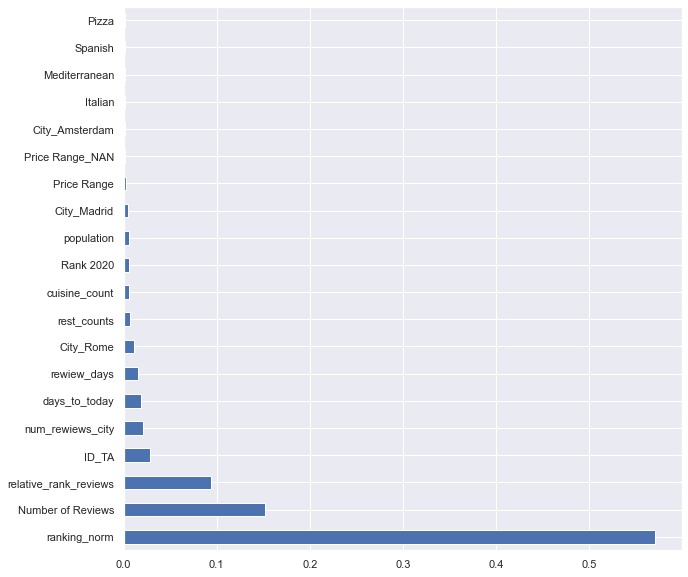

In [106]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [107]:
test_data.sample(10)

,Price Range,Number of Reviews,ID_TA,Rating,population,Rank 2020,rest_counts,Cuisine Style_NAN,cuisine_count,cuisine_rare,...,City_Munich,City_Oslo,City_Paris,City_Porto,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich
5384,2,238.0,2615358,0.0,2.87,28,2589,0,6,0,...,0,0,0,0,0,1,0,0,0,0
5109,2,35.0,12624975,0.0,2.87,28,2589,0,1,0,...,0,0,0,0,0,1,0,0,0,0
2624,2,339.0,1083185,0.0,1.03,17,1372,0,5,0,...,0,0,0,0,0,0,0,0,0,0
8459,2,621.0,1653208,0.0,10.98,33,7193,0,7,0,...,0,0,0,0,0,0,0,0,0,0
5793,3,112.0,12873128,0.0,4.59,42,3395,0,3,0,...,0,0,0,0,0,0,0,0,0,0
3412,2,236.0,2267571,0.0,1.84,30,1186,0,3,0,...,0,0,0,0,0,0,0,0,0,0
8682,2,14.0,10259583,0.0,1.84,30,1186,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4880,2,220.0,6490170,0.0,10.98,33,7193,0,6,0,...,0,0,0,0,0,0,0,0,0,0
6949,2,101.0,5256816,0.0,11.02,14,6108,0,2,0,...,0,0,1,0,0,0,0,0,0,0
9274,2,8.0,8145208,0.0,1.84,24,1443,1,1,0,...,0,0,0,0,0,0,0,1,0,0


In [108]:
test_data = test_data.drop(['Rating'], axis=1)

In [109]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [110]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


In [111]:
for i in range(predict_submission.size):
        predict_submission[i]=rating(predict_submission[i])

In [112]:
predict_submission

array([3. , 4.5, 4.5, ..., 3. , 4.5, 4.5])

In [113]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.5
2,id_2,4.5
3,id_3,4.5
4,id_4,4.5
5,id_5,4.5
6,id_6,2.0
7,id_7,2.5
8,id_8,4.0
9,id_9,4.5
